# DBN - Deep Belief Network

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [ ]:

# --- RBM Implementation ---
class RBM(tf.Module):
    def __init__(self, n_visible, n_hidden, name=None):
        super().__init__(name=name)
        self.n_visible = n_visible
        self.n_hidden = n_hidden
        self.W = tf.Variable(tf.random.normal([n_visible, n_hidden], stddev=0.01))
        self.h_bias = tf.Variable(tf.zeros([n_hidden]))
        self.v_bias = tf.Variable(tf.zeros([n_visible]))

    def sample_prob(self, probs):
        return tf.cast(tf.random.uniform(tf.shape(probs)) < probs, tf.float32)

    def v_to_h(self, v):
        h_prob = tf.nn.sigmoid(tf.matmul(v, self.W) + self.h_bias)
        return h_prob, self.sample_prob(h_prob)

    def h_to_v(self, h):
        v_prob = tf.nn.sigmoid(tf.matmul(h, tf.transpose(self.W)) + self.v_bias)
        return v_prob, self.sample_prob(v_prob)

    def contrastive_divergence(self, v0, lr=0.01):
        h0_prob, h0_sample = self.v_to_h(v0)
        v1_prob, v1_sample = self.h_to_v(h0_sample)
        h1_prob, _ = self.v_to_h(v1_sample)

        W_update = tf.matmul(tf.transpose(v0), h0_prob) - tf.matmul(tf.transpose(v1_sample), h1_prob)
        self.W.assign_add(lr * W_update / tf.cast(tf.shape(v0)[0], tf.float32))
        self.v_bias.assign_add(lr * tf.reduce_mean(v0 - v1_sample, axis=0))
        self.h_bias.assign_add(lr * tf.reduce_mean(h0_prob - h1_prob, axis=0))

        loss = tf.reduce_mean(tf.square(v0 - v1_prob))
        return loss

    def forward(self, v):
        h_prob, _ = self.v_to_h(v)
        return h_prob


In [ ]:
# --- Preprocessing ---
def preprocess(x):
    x = x.astype(np.float32) / 255.
    return x.reshape(-1, 784)

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = preprocess(x_train)
x_test = preprocess(x_test)


In [ ]:

# --- RBM Training ---
def train_rbm(rbm, data, epochs=5, batch_size=64, lr=0.01):
    for epoch in range(epochs):
        losses = []
        for i in range(0, len(data), batch_size):
            batch = tf.convert_to_tensor(data[i:i+batch_size])
            loss = rbm.contrastive_divergence(batch, lr)
            losses.append(loss.numpy())
        print(f"RBM {rbm.n_visible}->{rbm.n_hidden} | Epoch {epoch+1}, Loss: {np.mean(losses):.4f}")


In [ ]:
# --- Stack RBMs for DBN Pretraining ---
rbm1 = RBM(784, 512)
train_rbm(rbm1, x_train, epochs=1)

h1_train = rbm1.forward(tf.convert_to_tensor(x_train)).numpy()
rbm2 = RBM(512, 256)
train_rbm(rbm2, h1_train, epochs=1)

h2_train = rbm2.forward(tf.convert_to_tensor(h1_train)).numpy()


RBM 784->512 | Epoch 1, Loss: 0.0514
RBM 512->256 | Epoch 1, Loss: 0.0238


In [15]:
from tensorflow.keras.layers import Input , Dense
from tensorflow.keras.models import Sequential

model = Sequential()
model.add(Input(shape=(784,)))

model.add(Dense(
    512, activation='sigmoid'
))

model.layers[-1].set_weights([rbm1.W.numpy(),rbm1.h_bias.numpy()])

model.add(Dense(
    256, activation='sigmoid'
))

model.layers[-1].set_weights([rbm2.W.numpy(),rbm2.h_bias.numpy()])

model.add(Dense(10, activation='softmax'))

model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (None, 512)            │       401,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 535,818 (2.04 MB)

 Trainable params: 535,818 (2.04 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:

# --- Fine-tune with Supervised Learning ---
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(x_train, y_train, epochs=10, batch_size=64, validation_split=0.1)

# --- Evaluate ---
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"\nTest Accuracy: {test_acc:.4f}")


Epoch 1/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.7970 - loss: 0.6632 - val_accuracy: 0.9570 - val_loss: 0.1513
Epoch 2/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9481 - loss: 0.1707 - val_accuracy: 0.9700 - val_loss: 0.1090
Epoch 3/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.9662 - loss: 0.1144 - val_accuracy: 0.9748 - val_loss: 0.0908
Epoch 4/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9757 - loss: 0.0813 - val_accuracy: 0.9748 - val_loss: 0.0913
Epoch 5/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9813 - loss: 0.0617 - val_accuracy: 0.9777 - val_loss: 0.0746
Epoch 6/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9865 - loss: 0.0453 - val_accuracy: 0.9752 - val_loss: 0.0817
Epoch 7/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9895 - loss: 0.0343 - val_accuracy: 0.9800 - val_loss: 0.0719
Epoch 8/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9926 - loss: 0.0256 - val_accuracy: 0.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


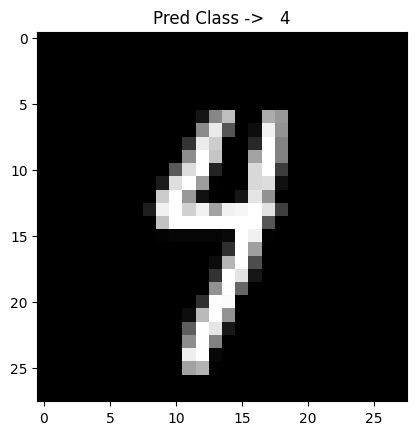

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

sample = x_test[0].reshape(1,784)

pred  = model.predict(sample)
pred_label = np.argmax(pred)

plt.title(f"Pred Class ->   {pred_label}")
plt.imshow(sample.reshape(28,28),cmap='gray')

In [8]:
rbm1.W.shape

TensorShape([784, 512])

In [9]:
rbm2.W.shape

TensorShape([512, 256])

In [10]:
rbm1.h_bias.shape

TensorShape([512])

In [11]:
rbm2.h_bias.shape

TensorShape([256])